In [1]:
import os 
import PIL
import PIL.Image
import pathlib

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

/home/riri/Desktop/Tensorflow/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

3670

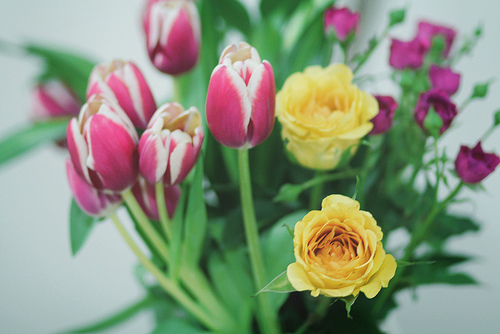

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[50]))

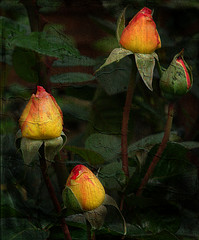

In [5]:
PIL.Image.open(str(roses[1]))

In [6]:
#Loading using the keras utility. From the local dataset.
batch_size = 32
height = 185
width = 185

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset="training", seed=123, 
    image_size=(height, width), batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset="validation", seed=123, 
    image_size=(height, width), batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_name = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


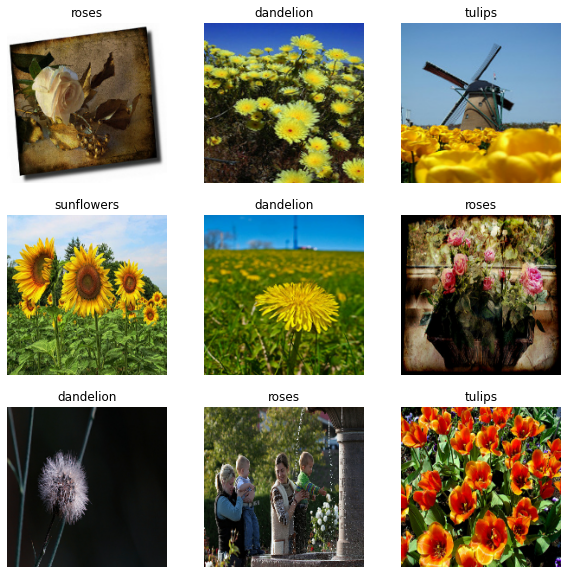

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis('off')


In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 185, 185, 3)
(32,)


In [11]:
# Standardizing the data to be ideal for the neural network.
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
#There are 2 wasys to use this layer; ny using dataset.map or including the layer in the model definition.
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))#IMages are now sclaed to [0, 1]


0.0 0.97217953


In [13]:
#Configuring the dataset for performance., cahce stores the images in memory after they're loaded off
# the disk after first epoch, prefetch overlaps the preprocessing and model execution wile trainn.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#Training the model.
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)
])

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/5


92/92 [==============================] - 272s 3s/step - loss: 1.2655 - accuracy: 0.4554 - val_loss: 1.0708 - val_accuracy: 0.5872
Epoch 2/5
92/92 [==============================] - 274s 3s/step - loss: 1.0030 - accuracy: 0.6035 - val_loss: 0.9763 - val_accuracy: 0.6199
Epoch 3/5
92/92 [==============================] - 223s 2s/step - loss: 0.8145 - accuracy: 0.6887 - val_loss: 1.0090 - val_accuracy: 0.6349
Epoch 4/5
92/92 [==============================] - 186s 2s/step - loss: 0.6808 - accuracy: 0.7439 - val_loss: 0.9769 - val_accuracy: 0.6512
Epoch 5/5
92/92 [==============================] - 200s 2s/step - loss: 0.5251 - accuracy: 0.8018 - val_loss: 1.0534 - val_accuracy: 0.6240


In [19]:
#Using tf.data for finer control.
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for file in list_ds.take(5):
    print(file.numpy())

b'/home/riri/.keras/datasets/flower_photos/daisy/22244161124_53e457bb66_n.jpg'
b'/home/riri/.keras/datasets/flower_photos/sunflowers/15839183375_49bf4f75e8_m.jpg'
b'/home/riri/.keras/datasets/flower_photos/tulips/6905876618_12732b74de_b.jpg'
b'/home/riri/.keras/datasets/flower_photos/dandelion/3393060921_2328b752f4.jpg'
b'/home/riri/.keras/datasets/flower_photos/dandelion/14740350060_a489d9fa06.jpg'


In [21]:
#class names from the tree structure.
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [22]:
#Split the data into training and validation sets.
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

#Size of each set.
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [23]:
#Custom func to convert file path to img, label.
def get_label(file_path):
    #Convert path to a list of path components.
    parts = tf.strings.split(file_path, os.path.sep)
    #The seconfd last is the class name.
    one_hot = parts[-2] == class_names
    #integer encode the label
    return tf.argmax(one_hot)


def decode_img(img):
    #Convert the compressed string to a 3D uint8 tensor.
    img = tf.io.decode_jpeg(img, channels=3)
    #Resize the img.
    return tf.image.resize(img, [height, width])

def process_path(file_path):
    label = get_label(file_path)
    #Load the raw data from the file as a string.
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [24]:
# Using .map to create them datasets.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
for img, label in train_ds.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label: {}".format(label.numpy()))

Image shape: (185, 185, 3)
Label: 2


In [28]:
# Configuring dataset for performance.
def configure_dataset(ds):
    ds =ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds = configure_dataset(train_ds)
val_ds = configure_dataset(val_ds)

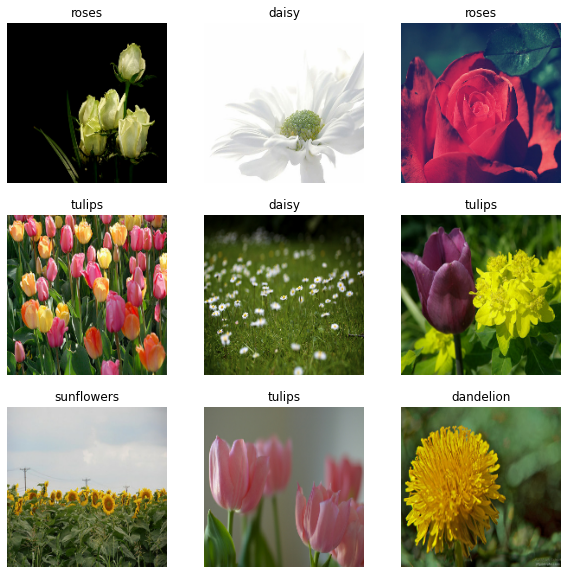

In [30]:
#Visualize.
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i +1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')


In [32]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 376s 4s/step - loss: 0.5048 - accuracy: 0.8277 - val_loss: 0.4684 - val_accuracy: 0.8379
Epoch 2/3
92/92 [==============================] - 413s 4s/step - loss: 0.3033 - accuracy: 0.8913 - val_loss: 0.5907 - val_accuracy: 0.7970
Epoch 3/3
92/92 [==============================] - 755s 8s/step - loss: 0.1846 - accuracy: 0.9455 - val_loss: 0.5777 - val_accuracy: 0.8120


In [41]:
#Using tf Datasets.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True,
)

Dl Completed...:  60%|██████    | 3/5 [10:03<00:04,  2.26s/ file]

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label(label))